# Baseline DNN model based on anatomy features with Torch

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn

In [3]:
from problem import get_train_data, get_test_data

data_train, labels_train = get_train_data(path=path)
data_test, labels_test = get_test_data(path=path)

In [4]:
data_train.shape, data_test.shape

((1127, 220), (23, 220))

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from problem import get_cv

def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

### Basic DNN

In [42]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [63]:
class AnatomyDataset(Dataset):
    
    def __init__(self, data, labels, transforms=None, target_transforms=None):
        self.data = data
        self.labels = labels
        assert len(labels) == len(data)
        self.transforms = (lambda x: x) if transforms is None else transforms
        self.target_transforms = (lambda x: x) if target_transforms is None else target_transforms
         
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.transforms(self.data[index, :]), self.target_transforms(self.labels[index])
    

mean = data_train[anatomy_cols].values.mean(axis=0)
std = data_train[anatomy_cols].values.std(axis=0)

train_dataset = AnatomyDataset(data_train[anatomy_cols].values, labels_train, 
                               transforms=Compose([Normalize(mean, std), ToTensor()]))

In [64]:
class Compose:
    
    def __init__(self, tfs):
        self.transforms = tfs
        
    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x


class Normalize:
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, x):
        return (x - self.mean) / (self.std + 1e-10)
      
        
class ToTensor:
    
    def __call__(self, x):
        return torch.tensor(x)
        

In [66]:
len(train_dataset), train_dataset[0][0].shape, train_dataset[0][1]

(1127, torch.Size([207]), 0)

In [28]:
class AnatomyBasedDNN(nn.Module):
    
    def __init__(self, in_planes, out_planes):
        super(AnatomyBasedDNN, self).__init__()
        
        self.f1 = nn.Sequential(
            nn.Linear(in_planes, in_planes),
            nn.BatchNorm1d(in_planes),            
        )
        
        self.f1a = nn.Sequential(
            nn.ELU(alpha=0.7),
            nn.Linear(in_planes, in_planes),
            nn.BatchNorm1d(in_planes),      
            nn.ELU(alpha=0.7)
        )
        
        self.f2 = nn.Sequential(
            nn.Linear(in_planes, 2 * in_planes),
            nn.BatchNorm1d(2 * in_planes),
            nn.ELU(alpha=0.7),
            nn.Linear(2 * in_planes, in_planes),
            nn.BatchNorm1d(in_planes),
            nn.ELU(alpha=0.7), 
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(in_planes, in_planes // 2),
            nn.BatchNorm1d(in_planes // 2),            
            nn.ReLU(inplace=True),
            nn.Linear(in_planes // 2, in_planes // 4),
            nn.BatchNorm1d(in_planes // 4),
            nn.ReLU(inplace=True),
            nn.Linear(in_planes // 4, in_planes // 8),
            nn.BatchNorm1d(in_planes // 8),            
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_planes // 8, out_planes),            
        )
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        
        x1 = self.f1(x)
        x1 = self.f1a(x1 * x)
        
        x2 = self.f2(x)
        x3 = x1 + x2

        return self.classifier(x3)


In [29]:
model = AnatomyBasedDNN(len(anatomy_cols), out_planes=2)

In [68]:
from torch.optim import Adam

from ignite.engine import create_supervised_trainer, Events

In [31]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

anatomy_cols = [col for col in data_train.columns if col.startswith('anatomy')]
anatomy_cols.remove('anatomy_select')

data_transform = Compose([Normalize(mean, std), ToTensor()]

device = "cpu"


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[anatomy_cols]
        return X
        

class Classifier(BaseEstimator):
    def __init__(self):                
        self.model = AnatomyBasedDNN(len(anatomy_cols), out_planes=2)
        self.optimizer = Adam(self.model.parameter(), lr=0.001)
        self.loss = nn.CrossEntropyLoss()
        self.trainer = create_supervised_trainer(self.model, self.optimizer, loss_fn=self.loss, device=device)
    
        @self.trainer.on(Events.EPOCH_COMPLETED)
        def log_training(engine):
            print("Epoch {}".format(engine.state.epoch))

    def fit(self, X, y):
        
        dataset = AnatomyDataset(X.values, y, transforms=data_transform)
        data_loader = DataLoader(dataset, batch_size=10, num_workers=4, shuffle=True)        
        self.trainer.run(data_loader, max_epochs=10)        
        return self
        
    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


In [7]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.850 +- 0.004
Validation score ROC-AUC: 0.652 +- 0.016 

Training score accuracy: 0.772 +- 0.007
Validation score accuracy: 0.621 +- 0.016


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s finished


Let's visualize feature importance:

In [8]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [9]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [10]:
log_reg = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

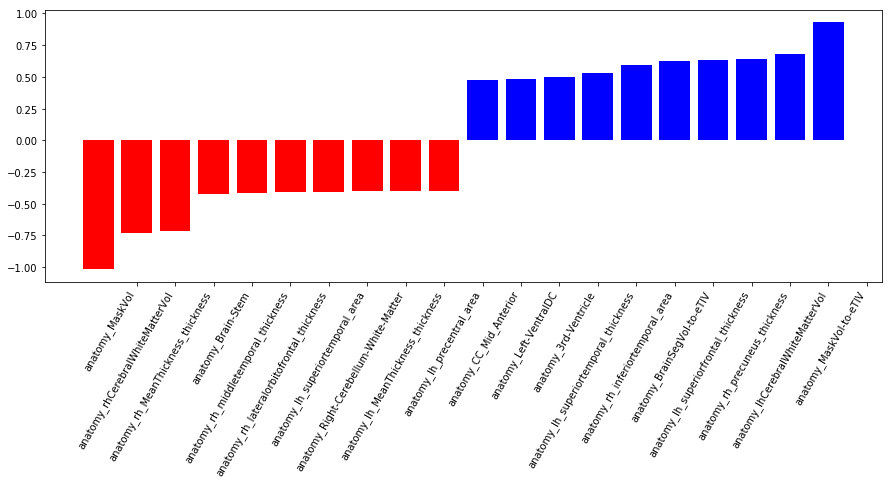

In [11]:
cols=[col for col in data_train.columns if col.startswith('anatomy')]

visualize_coefficients(log_reg, feature_names=cols, n_top_features=10)

In [12]:
n_top_features = 41
coef = log_reg.coef_.ravel()
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

In [13]:
topk_feature_names = np.array(cols)[interesting_coefficients].tolist()

### Basic logistic regression with filtered features 

In [18]:
topk_feature_names = [
    'anatomy_MaskVol', 'anatomy_rhCerebralWhiteMatterVol', 'anatomy_rh_MeanThickness_thickness', 'anatomy_Brain-Stem',
    'anatomy_rh_middletemporal_thickness', 'anatomy_rh_lateralorbitofrontal_thickness', 'anatomy_lh_superiortemporal_area',
    'anatomy_Right-Cerebellum-White-Matter', 'anatomy_lh_MeanThickness_thickness', 'anatomy_lh_precentral_area',
    'anatomy_rh_insula_thickness', 'anatomy_lh_rostralmiddlefrontal_area', 'anatomy_rh_pericalcarine_area',
    'anatomy_lh_pericalcarine_area',
    'anatomy_lh_lateralorbitofrontal_area',
    'anatomy_BrainSegVol',
    'anatomy_lh_entorhinal_area',
    'anatomy_lh_superiorparietal_area',
    'anatomy_rh_middletemporal_area',
    'anatomy_BrainSegVolNotVent',
    'anatomy_rhSurfaceHoles',
    'anatomy_lhCortexVol',
    'anatomy_SupraTentorialVolNotVentVox',
    'anatomy_rh_medialorbitofrontal_area',
    'anatomy_Left-Thalamus-Proper',
    'anatomy_CC_Posterior',
    'anatomy_rh_inferiorparietal_area',
    'anatomy_rh_temporalpole_area',
    'anatomy_lh_frontalpole_area',
    'anatomy_lh_caudalanteriorcingulate_area',
    'anatomy_rh_fusiform_area',
    'anatomy_Right-Accumbens-area',
    'anatomy_CC_Central',
    'anatomy_rh_caudalmiddlefrontal_thickness',
    'anatomy_Right-Amygdala',
    'anatomy_lh_entorhinal_thickness',
    'anatomy_lh_lateralorbitofrontal_thickness',
    'anatomy_lh_precentral_thickness',
    'anatomy_rh_postcentral_thickness',
    'anatomy_Left-Caudate',
    'anatomy_rh_insula_area',
    'anatomy_lh_inferiortemporal_thickness',
    'anatomy_lh_insula_thickness',
    'anatomy_rh_entorhinal_thickness',
    'anatomy_Left-Inf-Lat-Vent',
    'anatomy_rh_precentral_area',
    'anatomy_rh_frontalpole_area',
    'anatomy_WM-hypointensities',
    'anatomy_rh_rostralmiddlefrontal_area',
    'anatomy_rh_superiortemporal_thickness',
    'anatomy_Left-Hippocampus',
    'anatomy_Right-Pallidum',
    'anatomy_lh_insula_area',
    'anatomy_rhCortexVol',
    'anatomy_rh_precuneus_area',
    'anatomy_rh_bankssts_area',
    'anatomy_lh_medialorbitofrontal_thickness',
    'anatomy_eTIV',
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_rh_rostralmiddlefrontal_thickness',
    'anatomy_Left-Amygdala',
    'anatomy_rh_lateraloccipital_thickness',
    'anatomy_lh_lingual_area',
    'anatomy_rh_parsorbitalis_thickness',
    'anatomy_lhSurfaceHoles',
    'anatomy_lh_cuneus_thickness',
    'anatomy_SubCortGrayVol',
    'anatomy_Right-Cerebellum-Cortex',
    'anatomy_rh_superiorfrontal_area',
    'anatomy_lh_fusiform_thickness',
    'anatomy_lh_parsorbitalis_area',
    'anatomy_rh_lateraloccipital_area',
    'anatomy_CC_Mid_Anterior',
    'anatomy_Left-VentralDC',
    'anatomy_3rd-Ventricle',
    'anatomy_lh_superiortemporal_thickness',
    'anatomy_rh_inferiortemporal_area',
    'anatomy_BrainSegVol-to-eTIV',
    'anatomy_lh_superiorfrontal_thickness',
    'anatomy_rh_precuneus_thickness',
    'anatomy_lhCerebralWhiteMatterVol',
    'anatomy_MaskVol-to-eTIV']


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[topk_feature_names]
        return X
    
    
from sklearn.linear_model import LogisticRegressionCV
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(Cs=np.logspace(-2, 6, num=10), 
                                                     n_jobs=8, scoring="roc_auc"))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [19]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".for§mat(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.819 +- 0.004
Validation score ROC-AUC: 0.741 +- 0.018 

Training score accuracy: 0.744 +- 0.008
Validation score accuracy: 0.676 +- 0.018


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   17.6s finished


### Basic ElasticNet regression 

In [45]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.pipeline import make_pipeline


seed = 17

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[[col for col in X_df.columns if col.startswith('anatomy')]]
        return X.drop(columns='anatomy_select')
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), ElasticNet(alpha=0.015, l1_ratio=0.3, random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        probas = self.predict_proba(X)[:, 1]
        return (probas > 0.5).astype(np.int)

    def predict_proba(self, X):
        probas = self.clf.predict(X)
        probas = probas.reshape((-1, 1))
        return np.concatenate([probas, probas], axis=1)        


In [46]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.822 +- 0.004
Validation score ROC-AUC: 0.662 +- 0.017 

Training score accuracy: 0.741 +- 0.009
Validation score accuracy: 0.626 +- 0.030


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s finished


Let's visualize feature importance:

In [48]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [49]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [52]:
log_reg = pipe.named_steps['classifier'].clf.named_steps['elasticnet']

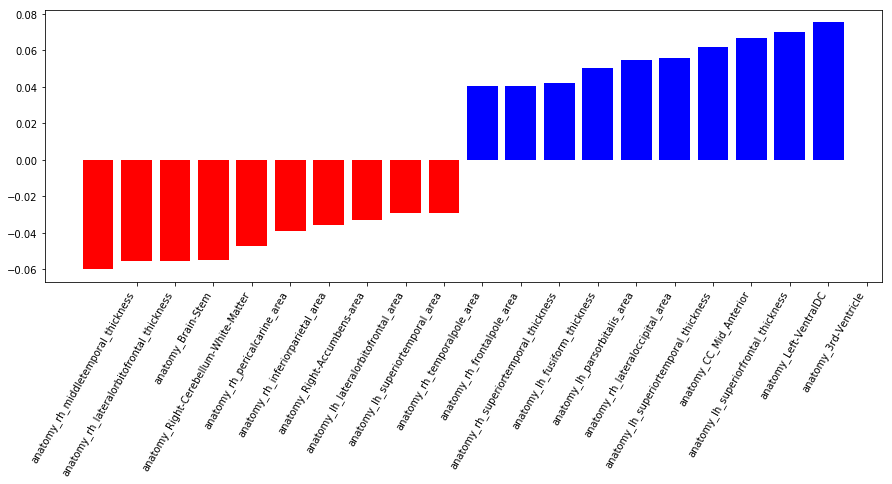

In [53]:
cols=[col for col in data_train.columns if col.startswith('anatomy')]

visualize_coefficients(log_reg, feature_names=cols, n_top_features=10)

In [121]:
n_top_features = 25
coef = log_reg.coef_.ravel()
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

In [122]:
topk_feature_names = np.array(cols)[interesting_coefficients].tolist()

### Basic ElasticNet with filtered features 

In [126]:
elasticnet_features = ['anatomy_rh_middletemporal_thickness',
 'anatomy_rh_lateralorbitofrontal_thickness',
 'anatomy_Brain-Stem',
 'anatomy_Right-Cerebellum-White-Matter',
 'anatomy_rh_pericalcarine_area',
 'anatomy_rh_inferiorparietal_area',
 'anatomy_Right-Accumbens-area',
 'anatomy_lh_lateralorbitofrontal_area',
 'anatomy_lh_superiortemporal_area',
 'anatomy_rh_temporalpole_area',
 'anatomy_lh_parahippocampal_thickness',
 'anatomy_rh_postcentral_thickness',
 'anatomy_lh_precentral_thickness',
 'anatomy_lh_entorhinal_area',
 'anatomy_rh_precentral_thickness',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_rh_medialorbitofrontal_area',
 'anatomy_lh_frontalpole_area',
 'anatomy_lh_caudalanteriorcingulate_area',
 'anatomy_lh_precentral_area',
 'anatomy_lh_inferiorparietal_thickness',
 'anatomy_lh_medialorbitofrontal_area',
 'anatomy_Left-Thalamus-Proper',
 'anatomy_CC_Central',
 'anatomy_rh_caudalanteriorcingulate_thickness',
 'anatomy_lh_temporalpole_area',
 'anatomy_Right-Cerebellum-Cortex',
 'anatomy_lh_lingual_area',
 'anatomy_lh_medialorbitofrontal_thickness',
 'anatomy_Left-Inf-Lat-Vent',
 'anatomy_rh_bankssts_area',
 'anatomy_rh_precuneus_area',
 'anatomy_rh_inferiortemporal_area',
 'anatomy_Left-Amygdala',
 'anatomy_rh_precuneus_thickness',
 'anatomy_rh_lateraloccipital_thickness',
 'anatomy_rh_superiorfrontal_area',
 'anatomy_WM-hypointensities',
 'anatomy_rh_parsorbitalis_thickness',
 'anatomy_lh_cuneus_thickness',
 'anatomy_rh_frontalpole_area',
 'anatomy_rh_superiortemporal_thickness',
 'anatomy_lh_fusiform_thickness',
 'anatomy_lh_parsorbitalis_area',
 'anatomy_rh_lateraloccipital_area',
 'anatomy_lh_superiortemporal_thickness',
 'anatomy_CC_Mid_Anterior',
 'anatomy_lh_superiorfrontal_thickness',
 'anatomy_Left-VentralDC',
 'anatomy_3rd-Ventricle']



class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[elasticnet_features]
        return X
    
    
from sklearn.linear_model import ElasticNetCV, ElasticNet
        

seed = 15    

    
class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        l1_ratio = 0.4
        pipe_cv = make_pipeline(StandardScaler(), 
                        ElasticNetCV(l1_ratio=l1_ratio, n_jobs=8, random_state=seed, max_iter=10000))
        pipe_cv.fit(X, y)
        best_alpha = pipe_cv.named_steps['elasticnetcv'].alpha_        
        self.clf = make_pipeline(StandardScaler(), 
                                 ElasticNet(l1_ratio=l1_ratio, alpha=best_alpha, 
                                            random_state=seed, max_iter=10000))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        probas = self.predict_proba(X)[:, 1]
        return (probas > 0.5).astype(np.int)
    
    def predict_proba(self, X):
        probas = self.clf.predict(X)
        probas = probas.reshape((-1, 1))
        return np.concatenate([probas, probas], axis=1)        



In [127]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.785 +- 0.004
Validation score ROC-AUC: 0.735 +- 0.016 

Training score accuracy: 0.708 +- 0.007
Validation score accuracy: 0.665 +- 0.011


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s finished


In [108]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.789 +- 0.004
Validation score ROC-AUC: 0.732 +- 0.017 

Training score accuracy: 0.711 +- 0.006
Validation score accuracy: 0.672 +- 0.018


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.5s finished


Mix of LogReg+ElasticNet

In [156]:
logreg_features = [
    'anatomy_MaskVol', 'anatomy_rhCerebralWhiteMatterVol', 'anatomy_rh_MeanThickness_thickness', 'anatomy_Brain-Stem',
    'anatomy_rh_middletemporal_thickness', 'anatomy_rh_lateralorbitofrontal_thickness', 'anatomy_lh_superiortemporal_area',
    'anatomy_Right-Cerebellum-White-Matter', 'anatomy_lh_MeanThickness_thickness', 'anatomy_lh_precentral_area',
    'anatomy_rh_insula_thickness', 'anatomy_lh_rostralmiddlefrontal_area', 'anatomy_rh_pericalcarine_area',
    'anatomy_lh_pericalcarine_area',
    'anatomy_lh_lateralorbitofrontal_area',
    'anatomy_BrainSegVol',
    'anatomy_lh_entorhinal_area',
    'anatomy_lh_superiorparietal_area',
    'anatomy_rh_middletemporal_area',
    'anatomy_BrainSegVolNotVent',
    'anatomy_rhSurfaceHoles',
    'anatomy_lhCortexVol',
    'anatomy_SupraTentorialVolNotVentVox',
    'anatomy_rh_medialorbitofrontal_area',
    'anatomy_Left-Thalamus-Proper',
    'anatomy_CC_Posterior',
    'anatomy_rh_inferiorparietal_area',
    'anatomy_rh_temporalpole_area',
    'anatomy_lh_frontalpole_area',
    'anatomy_lh_caudalanteriorcingulate_area',
    'anatomy_rh_fusiform_area',
    'anatomy_Right-Accumbens-area',
    'anatomy_CC_Central',
    'anatomy_rh_caudalmiddlefrontal_thickness',
    'anatomy_Right-Amygdala',
    'anatomy_lh_entorhinal_thickness',
    'anatomy_lh_lateralorbitofrontal_thickness',
    'anatomy_lh_precentral_thickness',
    'anatomy_rh_postcentral_thickness',
    'anatomy_Left-Caudate',
    'anatomy_rh_insula_area',
    'anatomy_lh_inferiortemporal_thickness',
    'anatomy_lh_insula_thickness',
    'anatomy_rh_entorhinal_thickness',
    'anatomy_Left-Inf-Lat-Vent',
    'anatomy_rh_precentral_area',
    'anatomy_rh_frontalpole_area',
    'anatomy_WM-hypointensities',
    'anatomy_rh_rostralmiddlefrontal_area',
    'anatomy_rh_superiortemporal_thickness',
    'anatomy_Left-Hippocampus',
    'anatomy_Right-Pallidum',
    'anatomy_lh_insula_area',
    'anatomy_rhCortexVol',
    'anatomy_rh_precuneus_area',
    'anatomy_rh_bankssts_area',
    'anatomy_lh_medialorbitofrontal_thickness',
    'anatomy_eTIV',
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_rh_rostralmiddlefrontal_thickness',
    'anatomy_Left-Amygdala',
    'anatomy_rh_lateraloccipital_thickness',
    'anatomy_lh_lingual_area',
    'anatomy_rh_parsorbitalis_thickness',
    'anatomy_lhSurfaceHoles',
    'anatomy_lh_cuneus_thickness',
    'anatomy_SubCortGrayVol',
    'anatomy_Right-Cerebellum-Cortex',
    'anatomy_rh_superiorfrontal_area',
    'anatomy_lh_fusiform_thickness',
    'anatomy_lh_parsorbitalis_area',
    'anatomy_rh_lateraloccipital_area',
    'anatomy_CC_Mid_Anterior',
    'anatomy_Left-VentralDC',
    'anatomy_3rd-Ventricle',
    'anatomy_lh_superiortemporal_thickness',
    'anatomy_rh_inferiortemporal_area',
    'anatomy_BrainSegVol-to-eTIV',
    'anatomy_lh_superiorfrontal_thickness',
    'anatomy_rh_precuneus_thickness',
    'anatomy_lhCerebralWhiteMatterVol',
    'anatomy_MaskVol-to-eTIV']


elasticnet_features = ['anatomy_rh_middletemporal_thickness',
 'anatomy_rh_lateralorbitofrontal_thickness',
 'anatomy_Brain-Stem',
 'anatomy_Right-Cerebellum-White-Matter',
 'anatomy_rh_pericalcarine_area',
 'anatomy_rh_inferiorparietal_area',
 'anatomy_Right-Accumbens-area',
 'anatomy_lh_lateralorbitofrontal_area',
 'anatomy_lh_superiortemporal_area',
 'anatomy_rh_temporalpole_area',
 'anatomy_lh_parahippocampal_thickness',
 'anatomy_rh_postcentral_thickness',
 'anatomy_lh_precentral_thickness',
 'anatomy_lh_entorhinal_area',
 'anatomy_rh_precentral_thickness',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_rh_medialorbitofrontal_area',
 'anatomy_lh_frontalpole_area',
 'anatomy_lh_caudalanteriorcingulate_area',
 'anatomy_lh_precentral_area',
 'anatomy_lh_inferiorparietal_thickness',
 'anatomy_lh_medialorbitofrontal_area',
 'anatomy_Left-Thalamus-Proper',
 'anatomy_CC_Central',
 'anatomy_rh_caudalanteriorcingulate_thickness',
 'anatomy_lh_temporalpole_area',
 'anatomy_Right-Cerebellum-Cortex',
 'anatomy_lh_lingual_area',
 'anatomy_lh_medialorbitofrontal_thickness',
 'anatomy_Left-Inf-Lat-Vent',
 'anatomy_rh_bankssts_area',
 'anatomy_rh_precuneus_area',
 'anatomy_rh_inferiortemporal_area',
 'anatomy_Left-Amygdala',
 'anatomy_rh_precuneus_thickness',
 'anatomy_rh_lateraloccipital_thickness',
 'anatomy_rh_superiorfrontal_area',
 'anatomy_WM-hypointensities',
 'anatomy_rh_parsorbitalis_thickness',
 'anatomy_lh_cuneus_thickness',
 'anatomy_rh_frontalpole_area',
 'anatomy_rh_superiortemporal_thickness',
 'anatomy_lh_fusiform_thickness',
 'anatomy_lh_parsorbitalis_area',
 'anatomy_rh_lateraloccipital_area',
 'anatomy_lh_superiortemporal_thickness',
 'anatomy_CC_Mid_Anterior',
 'anatomy_lh_superiorfrontal_thickness',
 'anatomy_Left-VentralDC',
 'anatomy_3rd-Ventricle']



class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    
    
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.linear_model import ElasticNetCV, ElasticNet
        
    
seed = 72


class Classifier(BaseEstimator):
    def __init__(self):
        self.logreg = None
        self.elnet = None
        self.weights = [0.65, 0.35]

    def fit(self, X, y):
                
        l1_ratio = 0.5
        
        pipe1_cv = make_pipeline(StandardScaler(), 
                                 LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe2_cv = make_pipeline(StandardScaler(), 
                                 ElasticNetCV(l1_ratio=l1_ratio, n_jobs=8, random_state=seed, max_iter=10000))
                
        pipe1_cv.fit(X[logreg_features], y)
        pipe2_cv.fit(X[elasticnet_features], y)
        
        best_C = pipe1_cv.named_steps['logisticregressioncv'].C_[0]
        self.logreg = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        
        best_alpha = pipe2_cv.named_steps['elasticnetcv'].alpha_        
        self.elnet = make_pipeline(StandardScaler(), 
                                   ElasticNet(l1_ratio=l1_ratio, alpha=best_alpha, 
                                              random_state=seed, max_iter=10000))
         
        self.logreg.fit(X[logreg_features], y)
        self.elnet.fit(X[elasticnet_features], y)        
        return self
        
    def predict(self, X):        
        probas = self.predict_proba(X)[:, 1]
        return (probas > 0.5).astype(np.int)
    
    def predict_proba(self, X):
        pr1 = self.logreg_predict_proba(X)
        pr2 = self.elnet_predict_proba(X)
        probas = self.weights[0] * pr1 + self.weights[1] * pr2
        return probas
    
    def logreg_predict_proba(self, X):
        return self.logreg.predict_proba(X[logreg_features])
    
    def elnet_predict_proba(self, X):
        probas = self.elnet.predict(X[elasticnet_features])
        probas = probas.reshape((-1, 1))
        return np.concatenate([probas, probas], axis=1)                


In [157]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.817 +- 0.004
Validation score ROC-AUC: 0.745 +- 0.017 

Training score accuracy: 0.742 +- 0.006
Validation score accuracy: 0.680 +- 0.018


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.9s finished


Logreg only

In [19]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".for§mat(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.819 +- 0.004
Validation score ROC-AUC: 0.741 +- 0.018 

Training score accuracy: 0.744 +- 0.008
Validation score accuracy: 0.676 +- 0.018


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   17.6s finished
